2018 Edition<br>
<i>Luca LOMBARDO and Claudio SCALZO</i>

# Challenge: What is the future selling price of a home?

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

# The dataset

### File descriptions

* train.csv - <i>the training dataset</i>
* test.csv - <i>the test dataset</i>
* data_description.txt - <i>full description of each column</i>

# Goal of the challenge

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

### Metric
Notebooks are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Submission File Format
The file should contain a header and have the following format:

```
Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
```

You will find an example submission file within the data directory in the repository.

# Grading the notebook

This challenge is going to be graded as a regular notebook for the AML labs. As a consequence, students should submit:

* the html version of the notebook, using the Data Science Labs submission website, as usual [**Assignment: Challenge Notebook**]
* the submission file (in csv format), that we will use to rank students according to the metric defined above, again through the Data Science Labs submission website [**Assignment: Challenge Predictions**]

In summary, you will have to submit 2 files!

In [147]:
# LIBRARIES IMPORT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from copy import deepcopy
from time import time
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# INITS
sns.set(style="whitegrid", palette="Greens_r", font_scale=1.3)

# 0. Preliminary operations and dataset import

In [148]:
# PATH AND FILES
basePath = "./challenge_data/"
trainFile = basePath + "train.csv"
testFile = basePath + "test.csv"

In [149]:
# LOAD THE TRAINSET AND THE DATASET
train = pd.read_csv(trainFile)
test = pd.read_csv(testFile)

# PRINT TO DESCRIBE
print("Houses:", train.shape[0])
print("Attributes (except the ID):", train.shape[1] - 1)
train.head(10)

Houses: 1200
Attributes (except the ID): 80


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


<div class='alert alert-success'>
The dataset is very small, only 1200 lines (houses) with 81 rows (attributes + ID). We considered useless, in this case, the use of a distributed computing framework like <i>Apache Spark</i>: we're going to do all of our work locally, exploiting libraries which work on a local fashion.
</div>

# 1. Descriptive statistics about the data

In [150]:
# ANALYZE ONLY THE NUMERICAL VALUES
trainNumerical = train.select_dtypes(exclude="object").drop(columns=["Id"])

# COMPUTE SOME BASIC STATISTICS
print("Numerical attributes:", trainNumerical.shape[1])
trainNumerical.describe()

Numerical attributes: 37


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,45.260000,...,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,158.931453,...,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,0.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,...,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


<div class='alert alert-success'>
The numerical attributes (excluded the ID) are 37. Of course the "numerical" word doesn't have the same meaning for all of them: we can find years, which of course represent different values than prices, areas or lengths. However, being each of them numerical, we computed this description thank to which we can see some basic statistics on our data. For example, we can immediately see that until the 75th percentile no houses have a pool: this can me be useful for our model. We'll see later which attributes will impact more the model outcome.<br>
<br>
Before going ahead, let's analyze the categorical attributes:
</div>

In [151]:
# GET THE CATEGORICAL ATTRIBUTES
trainCategorical = train.select_dtypes(include="object")

# COMPUTE SOME BASIC STATISTICS
print("Categorical attributes:", trainCategorical.shape[1])
trainCategorical.describe()

Categorical attributes: 43


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1200,1200,75,1200,1200,1200,1200,1200,1200,1200,...,1133,1133,1133,1133,1200,4,227,47,1200,1200
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,946,1194,41,754,1079,1199,862,1135,179,1035,...,718,500,1081,1093,1107,2,130,44,1036,979


<div class='alert alert-success'>
For the categorical attributes of course we can't compute means, maxs or percentiles: they are not numeric values! However other kind of statistics can be computed: we can see for example that each attribute doesn't have the same count. Maybe there is something wrong, we are going to investigate about it in the next section <br>
<br>
Now, let's concentrate on out target variable: SalePrice.
</div>

## 1.1 Target variable

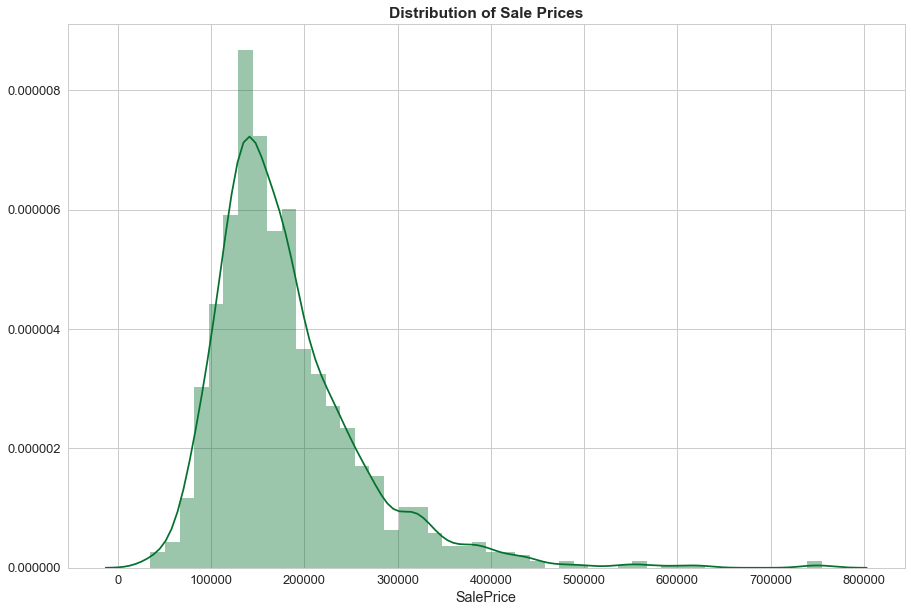

In [152]:
plt.figure(figsize=(15,10))
sns.distplot(train["SalePrice"])
plt.title("Distribution of Sale Prices", weight="semibold");

<div class='alert alert-success'>
We can see that is very frequent that our <i>SalePrice</i> has a value between <i>100'000&dollar;</i> and <i>200'000&dollar;</i>. The distribution is not symmetric but it's left-skewed, with a short tail on the left and a long tail on the right: this could lead to some difficulties for our model. We'll fix this aspect in the data pre-processing phase.<br>
<br>
Now let's build the correlation matrix (of course of the numerical attributes) and check which attributes have the strongest correlation between them:
</div>

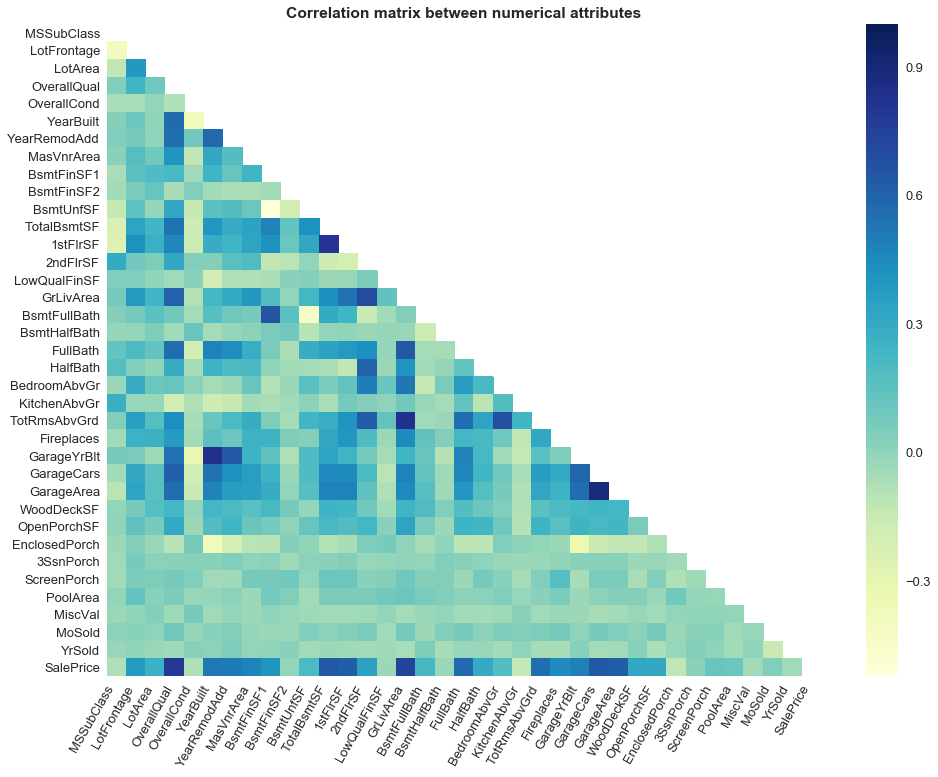

In [153]:
# BUILD THE CORRELATION MATRIX BETWEEN NUMERIC ATTRIBUTES
correlationMatrix = trainNumerical.corr()

# PLOT THE CORRELATION MATRIX
plt.figure(figsize=(16,12))
mask = np.zeros_like(correlationMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap="YlGnBu", mask=mask);
g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right");
plt.title("Correlation matrix between numerical attributes", weight="semibold");

<div class='alert alert-success'>
We can see that there are some values which are highly correlated. For example, <i>'GrLivArea' (Ground living area in square feet)</i> and <i>'TotRmsAbvGrd' (Total rooms above ground)</i>: this is clearly normal, because is highly probable that an house with a bigger ground living area has more rooms!<br>
There are also some negatively correlated attributes, like <i>'BsmtFullbath' (Full bathrooms in the basement)</i> and <i>'BsmtUnfSF' (Unfinished area in the basement)</i>, and this can be normal too: if there are a lot of bathrooms is highly unprobable that there is a big unfinished area in the same place.<br>
<br>
Of course these are just examples, what we can begin to care about are the attributes which are highly correlated with our target attribute: <i>'SalePrice'</i>. Let's check the correlation between the 6 most correlated:
</div>

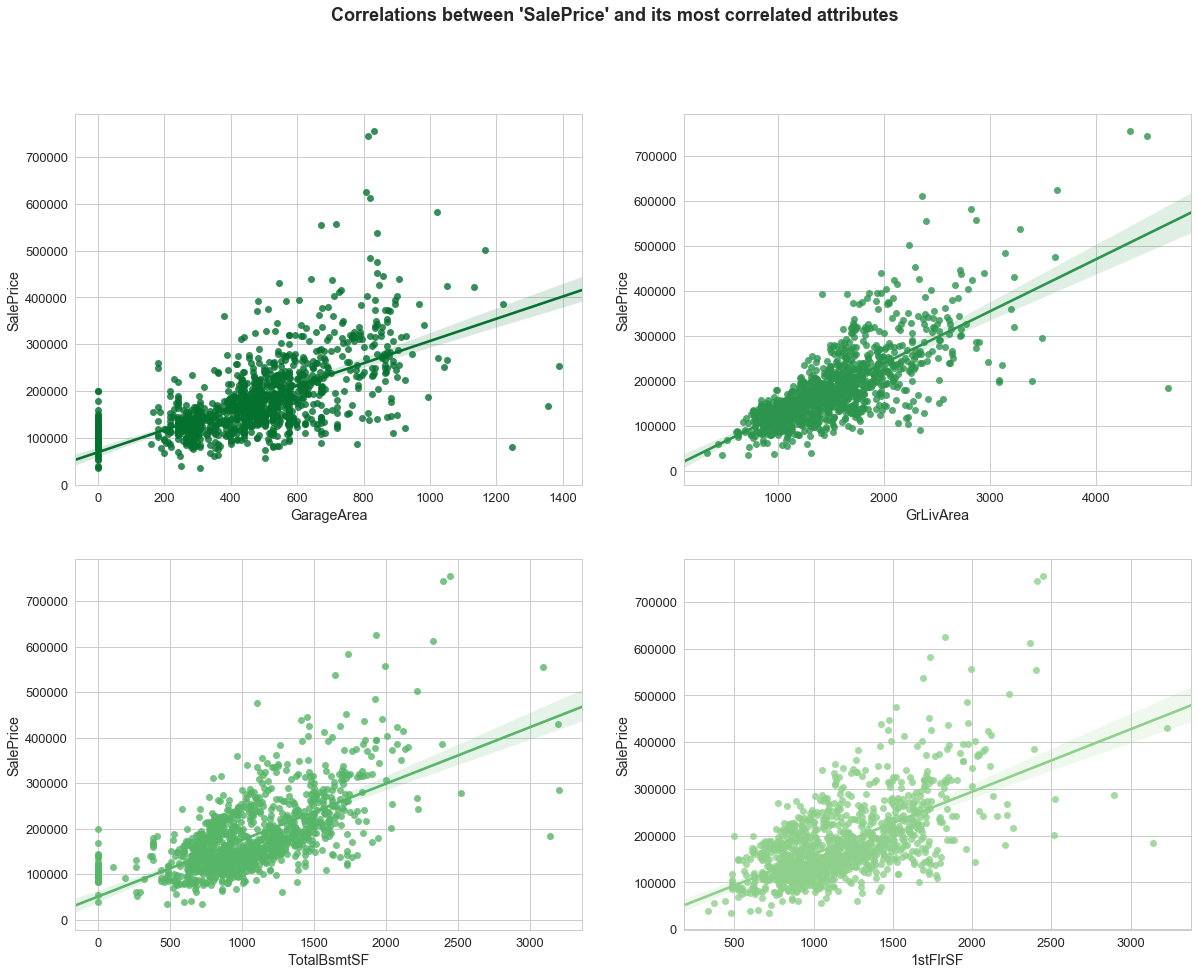

In [154]:
# PLOT THE CORRELATIONS BETWEEN 'SalePrice' AND ITS MOST CORRELATED ATTRIBUTES
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.regplot(x="GarageArea", y="SalePrice", data=train, ax=ax1);
sns.regplot(x="GrLivArea", y="SalePrice", data=train, ax=ax2);
sns.regplot(x="TotalBsmtSF", y="SalePrice", data=train, ax=ax3);
sns.regplot(x="1stFlrSF", y="SalePrice", data=train, ax=ax4);
plt.suptitle("Correlations between 'SalePrice' and its most correlated attributes", weight="semibold", fontsize=18);

<div class='alert alert-success'>
The attributes are of course correlated: we find that the garage area, the ground living area, the basement area and the 1st floor area are 4 of the most important attributes to decide the Sale Price of an house. What leads to some difficulties for the work of the linear regression are <b>outliers</b>: we're going to deal with them in the data pre-processing phase later.<br>
<br>
The other two highly correlated attributes are numerical outside, but categorical inside: indeed, we found out that they were just categorical (ordinal) attributes encoded with numeric values. For this reason, we're going to plot a boxplot instead of the regression plot. In the data pre-processing phase, we're going to transform all the attributes in numerical ones, and we'll recompute the correlation matrix.<br>
<br>
At the moment, let's draw the boxplots:
</div>

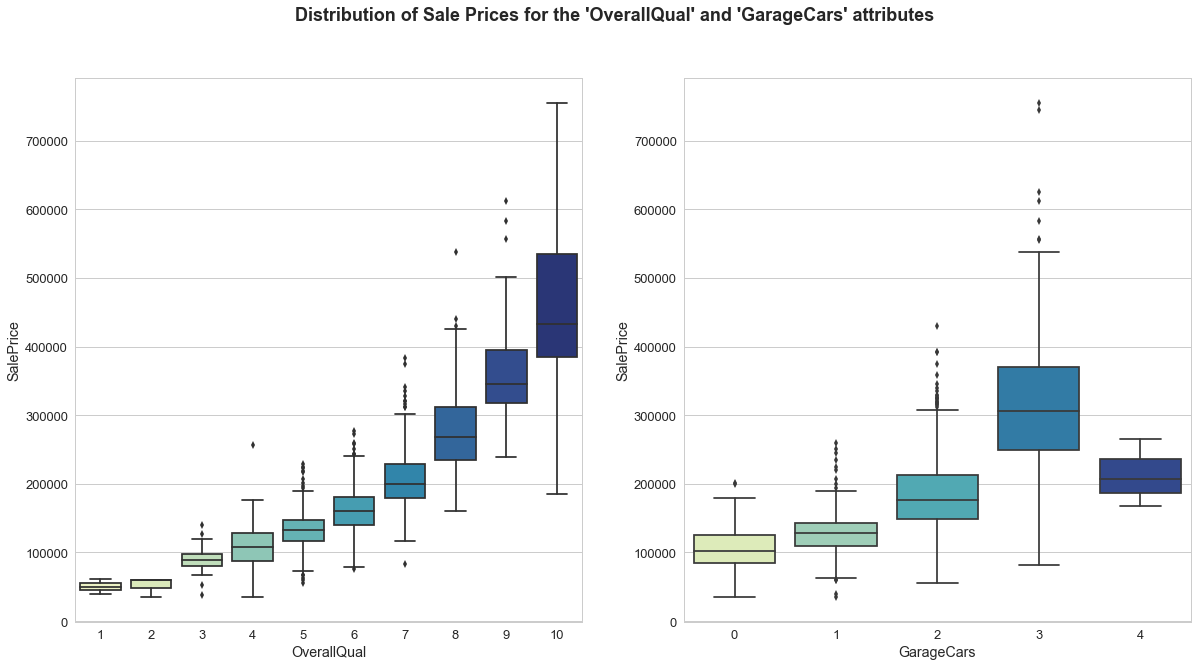

In [155]:
# PLOT THE BOXPLOTS FOR 'OverallQual' AND 'GarageCars' ATTRIBUTES
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.boxplot(x="OverallQual", y="SalePrice", data=train, ax=ax1, palette="YlGnBu");
sns.boxplot(x="GarageCars", y="SalePrice", data=train, ax=ax2, palette="YlGnBu");
plt.suptitle("Distribution of Sale Prices for the 'OverallQual' and 'GarageCars' attributes", weight="semibold", fontsize=18);

## 1.2 Missing values

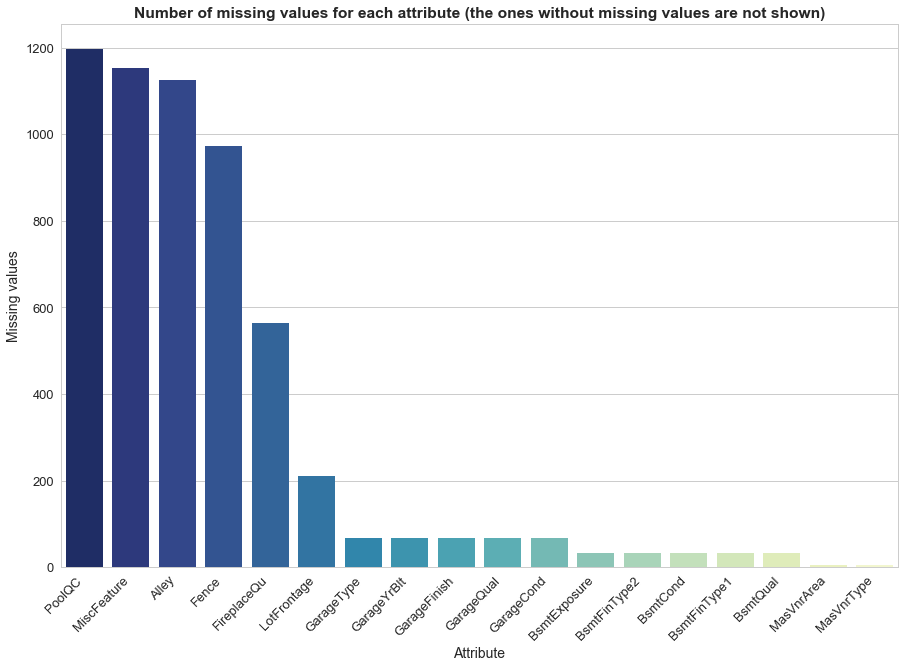

In [156]:
# EXPLORATIVE ANALYSIS ON MISSING VALUES
trainMissing = train.isnull().sum()
trainMissing = trainMissing[trainMissing != 0]
trainMissing = pd.DataFrame({"attribute":trainMissing.index, "count":trainMissing.values}).sort_values(by="count", ascending=False)

# PLOT THE BARPLOT
plt.figure(figsize=(15,10))
g = sns.barplot(x="attribute", y="count", data=trainMissing, palette="YlGnBu_r");
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right");
plt.xlabel("Attribute", fontsize=14);
plt.ylabel("Missing values", fontsize=14);
plt.title("Number of missing values for each attribute (the ones without missing values are not shown)", weight="semibold");

## 1.3 Basement attributes

## 1.4 Garage attributes

# 2. Data cleaning and pre-processing

## 2.1 Dealing with missing values

<div class='alert alert-success'>
The entire dataset contains, as often happens, a lot of missing values. It's important to notice that in each case, a missing value can have a <b>different meaning</b>: for example, can represent an unknown information, or can represent the lack of the property referred to that attribute! So, it's fundamental to look at the dataset description to check which is the exact meaning of the <i>NaN</i> value on a given column.<br>
<br>
We can start from categorical attributes. For them, every <i>NaN</i> represents just the lack of that given attribute (for example no pool, no basement): it's enough to fill all the missing values with the <i>"None"</i> value. Let's do that:
</div>

In [157]:
# CATEGORICAL ATTRIBUTES
categoricalAttributes = train.select_dtypes(include = "object").columns.values

# FILL THEM WITH THE None VALUE
for attribute in categoricalAttributes:
    train[attribute] = train[attribute].fillna("None")

<div class='alert alert-success'>
For numerical attributes the situations is a bit more complex. <br>
<br>
We can start from categorical attributes. For them, every <i>NaN</i> represent just the lack of that given attribute (for example no pool, no basement): it's enough to fill all the missing values with the <i>"None"</i> value. Let's do that:
</div>

In [158]:
# NUMERICAL ATTRIBUTES
# VALUES FOR WHICH NaN MEANS "NOT PRESENT"
zeroList = ["GarageYrBlt", "MasVnrArea"]

# FILL
for attribute in zeroList:
    train[attribute] = train[attribute].fillna(0)

In [159]:
train[train["Neighborhood"] == 'Mitchel'][["LotFrontage","LotArea"]].sort_values(by="LotArea", ascending=False).head(15)

,LotFrontage,LotArea
1190,NaN,32463
876,94.0,25286
943,100.0,25000
1048,100.0,21750
422,100.0,21750
5,85.0,14115
817,NaN,13265
46,48.0,12822
940,55.0,12640
767,75.0,12508


In [160]:
# LOT FRONTAGE ISSUE

# Create two copies: a read one and a write one
trainOnlyRead = deepcopy(train)

# For each row...
for index, row in train.iterrows():
    
    # ...if the 'LotFrontage' is NaN
    if np.isnan(row["LotFrontage"]):
        
        # Compute the neighborhood
        neighborhood = trainOnlyRead[trainOnlyRead["Neighborhood"] == row["Neighborhood"]]\
            [["LotFrontage", "LotArea"]].dropna().reset_index()
        
        # Take the index of the most similar street (in the neighborhood)
        closerIndex = (neighborhood["LotArea"] - row["LotArea"]).abs().argsort()[:1]
        
        # Assign the value to the original trainset
        train.at[index, "LotFrontage"] = neighborhood.loc[closerIndex]["LotFrontage"]

In [161]:
train[train["Neighborhood"] == 'Mitchel'][["LotFrontage","LotArea"]].sort_values(by="LotArea", ascending=False).head(15)

,LotFrontage,LotArea
1190,94.0,32463
876,94.0,25286
943,100.0,25000
1048,100.0,21750
422,100.0,21750
5,85.0,14115
817,48.0,13265
46,48.0,12822
940,55.0,12640
767,75.0,12508


## 2.2 Removing outliers

In [162]:
# REMOVING OUTLIERS FOR HIGHLY CORRELATED ATTRIBUTES
# GarageArea
print(train.shape)
train = train[((train["GarageArea"] < 1200) & (train["SalePrice"] < 125000))]
print(train.shape)

# GrLiveArea
train = train[((train["GrLivArea"] > 4000) & (train["SalePrice"] < 125000))]

# TotalBsmtSF
train = train[((train["TotalBsmtSF"] > 3000) & (train["SalePrice"] < 127500))]

# 1stFlrFS
train = train[((train["1stFlrSF"] > 3000) & (train["SalePrice"] < 127500))]

(1200, 81)
(249, 81)


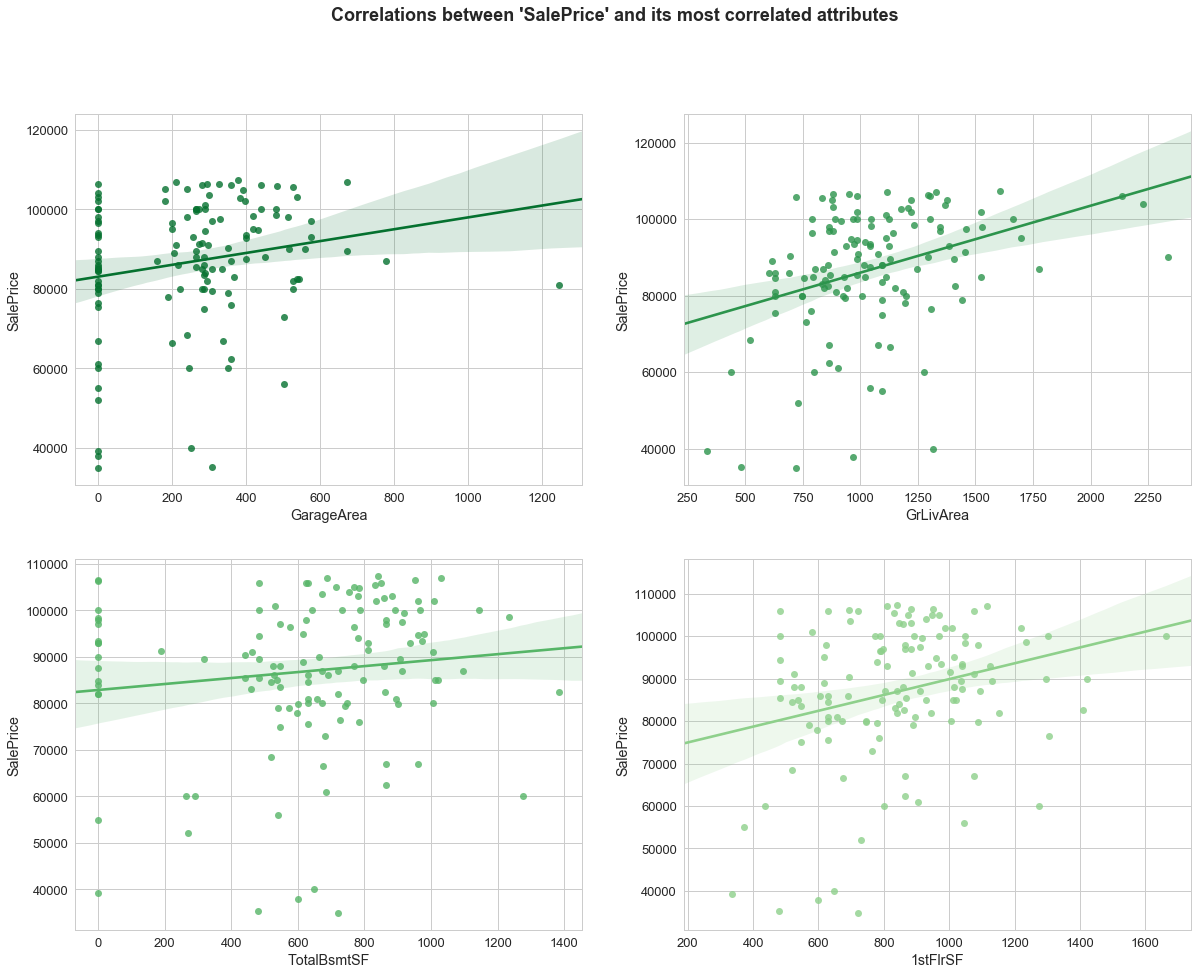

In [144]:
# PLOT AGAIN THE CORRELATIONS BETWEEN 'SalePrice' AND ITS MOST CORRELATED ATTRIBUTES
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.regplot(x="GarageArea", y="SalePrice", data=train, ax=ax1);
sns.regplot(x="GrLivArea", y="SalePrice", data=train, ax=ax2);
sns.regplot(x="TotalBsmtSF", y="SalePrice", data=train, ax=ax3);
sns.regplot(x="1stFlrSF", y="SalePrice", data=train, ax=ax4);
plt.suptitle("Correlations between 'SalePrice' and its most correlated attributes", weight="semibold", fontsize=18);

## 2.3 Feature engineering

## 2.4 Adjusting skewness of data

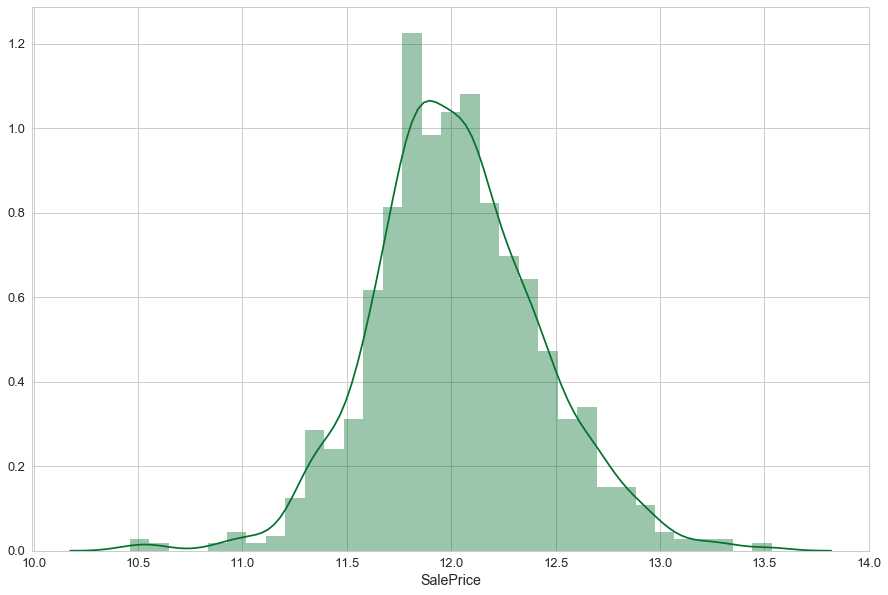

In [16]:
# NORMALIZE THE TARGET VARIABLE TO SIMPLIFY THE MODEL's WORK
train["SalePrice"] = np.log1p(train["SalePrice"])

# PLOT AGAIN THE VALUES DISTRIBUTION
plt.figure(figsize=(15,10))
sns.distplot(train["SalePrice"]);

## 2.5 Label Encoding

<div class='alert alert-success'>
Some categorical attributes are originally "objects" in our dataset. In order to make the model work, we have to transform them into numerical (ordinal) attributes, like the 'OverallQual' and 'OverallCond' originally are (scale from 1 to 10).<br>
<br>
We're going to use <b>Label Encoding</b> and not the <b>One Hot Encoding</b>, and we explain why:<br>
<br>
<list>
    <li>the Label Encoding is useful when we want to transform the categorical attribute in a numeric one, <b>keeping the ordinality information</b>. This means that if an attribute range is ["none", "bad", "average", "good", "excellent"], makes sense to transform it into [0, 1, 2, 3, 4].</li>
    <li>the One Hot Encoding is useful when we want to transform categorical attributes into numerical ones, but <b>without</b> letting the numerical value to be ordinal. This means that if an attribute has a domain range like ["red", "green", "blue"] can be a problem to transform it into a [0, 1, 2] range, because the model will learn an ordinality which is not present in reality! In these case we use a One Hot Encoding, that duplicates the columns for a given attribute, and gives the value 0 or 1.</li> 
</list><br>
In this case, analyzing all the attributes in the data description, we reached the conclusion that makes sense to use the Label Encoding in the whole dataset, because each of the categorical attributes has an "ordinality" feature.
</div>

In [17]:
# ENCODING FUNCTION
def encode(col):
    if col.dtype == np.object:
        return LabelEncoder().fit_transform(col)
    else:
        return col
    
# ENCODE THE CATEGORICAL VALUES IN NUMERICAL ONES
train = train.apply(encode, axis=0, reduce=False)

# SHOW
train.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,8,4,12.247699
1,2,20,3,80.0,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,8,4,12.109016
2,3,60,3,68.0,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,8,4,12.317171
3,4,70,3,60.0,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,8,0,11.849405
4,5,60,3,84.0,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,8,4,12.429220
5,6,50,3,85.0,14115,1,1,0,3,0,...,0,3,2,3,700,10,2009,8,4,11.870607
6,7,20,3,75.0,10084,1,1,3,3,0,...,0,3,4,1,0,8,2007,8,4,12.634606
7,8,60,3,80.0,10382,1,1,0,3,0,...,0,3,4,3,350,11,2009,8,4,12.206078
8,9,50,4,51.0,6120,1,1,3,3,0,...,0,3,4,1,0,4,2008,8,0,11.774528
9,10,190,3,50.0,7420,1,1,3,3,0,...,0,3,4,1,0,1,2008,8,4,11.678448


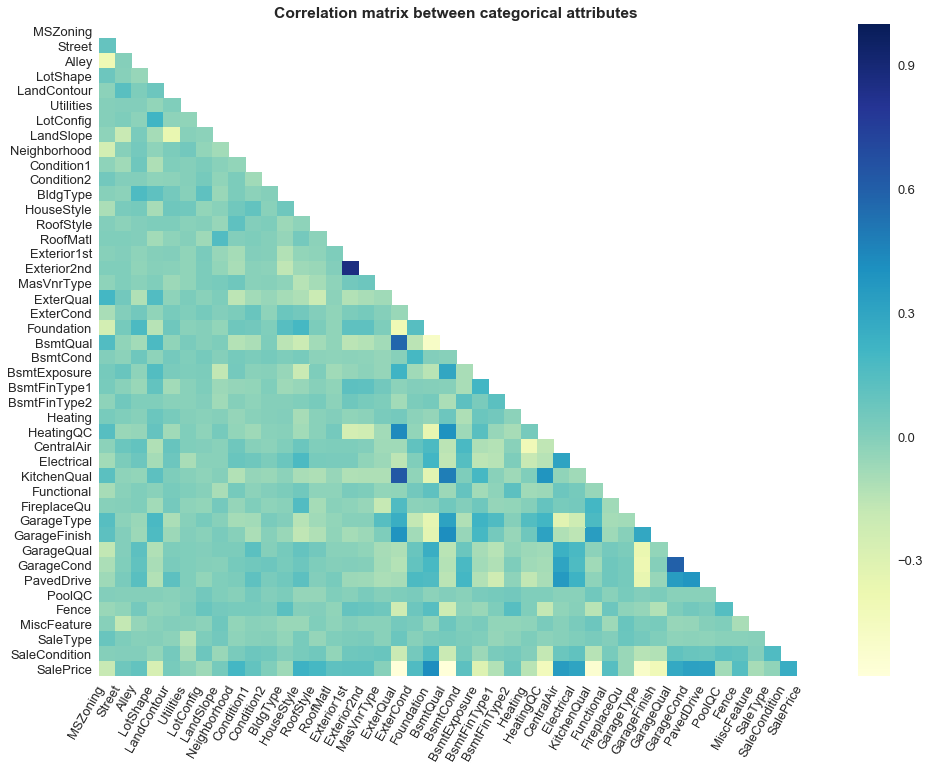

In [33]:
# PRINT AGAIN THE CORRELATION MATRIX (NOW THAT CATEGORICAL ATTRIBUTES HAVE BECOME NUMERICAL)
trainCategorical = train[np.append(categoricalAttributes, "SalePrice")]

# BUILD THE CORRELATION MATRIX BETWEEN CATEGORICAL ATTRIBUTES AND 'SalePrice'
correlationMatrix = trainCategorical.corr()

# PLOT THE CORRELATION MATRIX
plt.figure(figsize=(16,12))
mask = np.zeros_like(correlationMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
g = sns.heatmap(correlationMatrix, cmap="YlGnBu", mask=mask);
g.set_xticklabels(g.get_xticklabels(), rotation=60, ha="right");
plt.title("Correlation matrix between categorical attributes", weight="semibold");

<div class='alert alert-success'>
The correlation matrix highlights some high correlations between "Exterior1st" and "Exterior2nd" (the materials used to cover the house), or between the kitchen quality and the exterior quality. However, what do we care most is the last row: none of the attributes has a peak of correlation with our 'SalePrice' label. The numerical attributes had a bigger impact on our 'SalePrice' label.<br>
<br>
It's crucial to notice that for a lot of attributes, the sign of the correlation matrix is the opposite of what we expect: **this is normal** for our Label Encoding construction. The attributes in the lower steps get an high numerical value, the attributes in higher steps receive a low numerical value (e.g. No pool: 3, Bad pool: 2, etc.). We tried to change this behaviour but we didn't succedeed using only the methods provided by the scikit-learn library; we could have done an own algorithm, but it would have been uselessly time-spending and maybe not as efficient as the one in the library. It's just convention therefore we decided to leave things in this state.
</div>

# 3. Modeling